In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
from torchsummary import summary
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import alexnet
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
from PIL import Image

Mounted at /content/gdrive


In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/xAI/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)


In [4]:
class ALEXNET(nn.Module):
    def __init__(self):
        super(ALEXNET, self).__init__()

        self.alexnet_model = alexnet(pretrained=True)

        self.features_conv = self.alexnet_model.features[:12]

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.classifier = self.alexnet_model.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [5]:
# initialize the VGG model
alexnet_model = ALEXNET()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 95.8MB/s]


In [6]:
alexnet_model.alexnet_model


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
for param in alexnet_model.alexnet_model.parameters():
    param.requires_grad = False

In [8]:
alexnet_model.alexnet_model.classifier[6] = nn.Linear(4096, 2)
alexnet_model.alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
summary(alexnet_model.alexnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.alexnet_model.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [12]:
def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):

            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")

            image = image.resize((224,224))
            image_array = np.array(image) / 255.0
            # images.append(image_array)

            if ("target" in filename) & ("nontarget" not in filename):
                images.append(image_array)
                labels.append(1)
            elif "nontarget" in filename:
                images.append(image_array)
                labels.append(0)
            # else:
                # print(filename)
                # raise ValueError("Invalid filename format")

    return np.array(images), np.array(labels)

In [13]:
folder_path = '/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/Scalograms/'
X, Y = load_images_and_labels(folder_path)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (256, 224, 224, 3)
Shape of Y: (256,)


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images here i used imagenet stats
])


In [15]:
# Create dataset
dataset = CustomDataset(X, Y, transform=transform)

# Define data loader
batch_size = 16

# Split the dataset into training and testing subsets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
len(dataset)

256

In [17]:
test_dataset[0][1]

0

In [18]:
num_epochs = 1
for epoch in range(num_epochs):
    # Training loop
    alexnet_model.alexnet_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = alexnet_model.alexnet_model(images.float())
        # print(outputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    alexnet_model.alexnet_model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in test_loader:
            outputs = alexnet_model.alexnet_model(images.float())
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')




Epoch [1/1], Accuracy: 1.0000


# **Nontarget**

In [20]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/xAI/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [21]:
# set the evaluation mode
alexnet_model.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

In [23]:
img.requires_grad_(True)

tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2

In [24]:
alexnet_model(img)

tensor([[ 1.3175, -0.9009]], grad_fn=<AddmmBackward0>)

In [25]:
# get the most likely prediction of the model
pred_class = alexnet_model(img).argmax(dim=1).numpy()[0]
pred = alexnet_model(img)


In [26]:
pred[:, pred_class].backward()

In [28]:
# pull the gradients out of the model
gradients = alexnet_model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = alexnet_model.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(256):
    activations[:, i, :, :] *= pooled_gradients[i]

In [29]:
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()


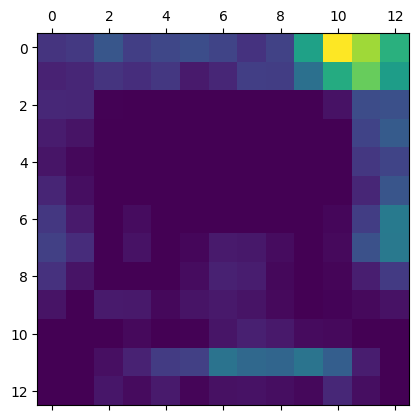

In [30]:
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [31]:
import cv2
img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/xAI/0/03_trial_51__nontarget.png')

heatmap = cv2.resize(np.array(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
# cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/Explainability/Dataset/Elephant/map.jpg', superimposed_img)

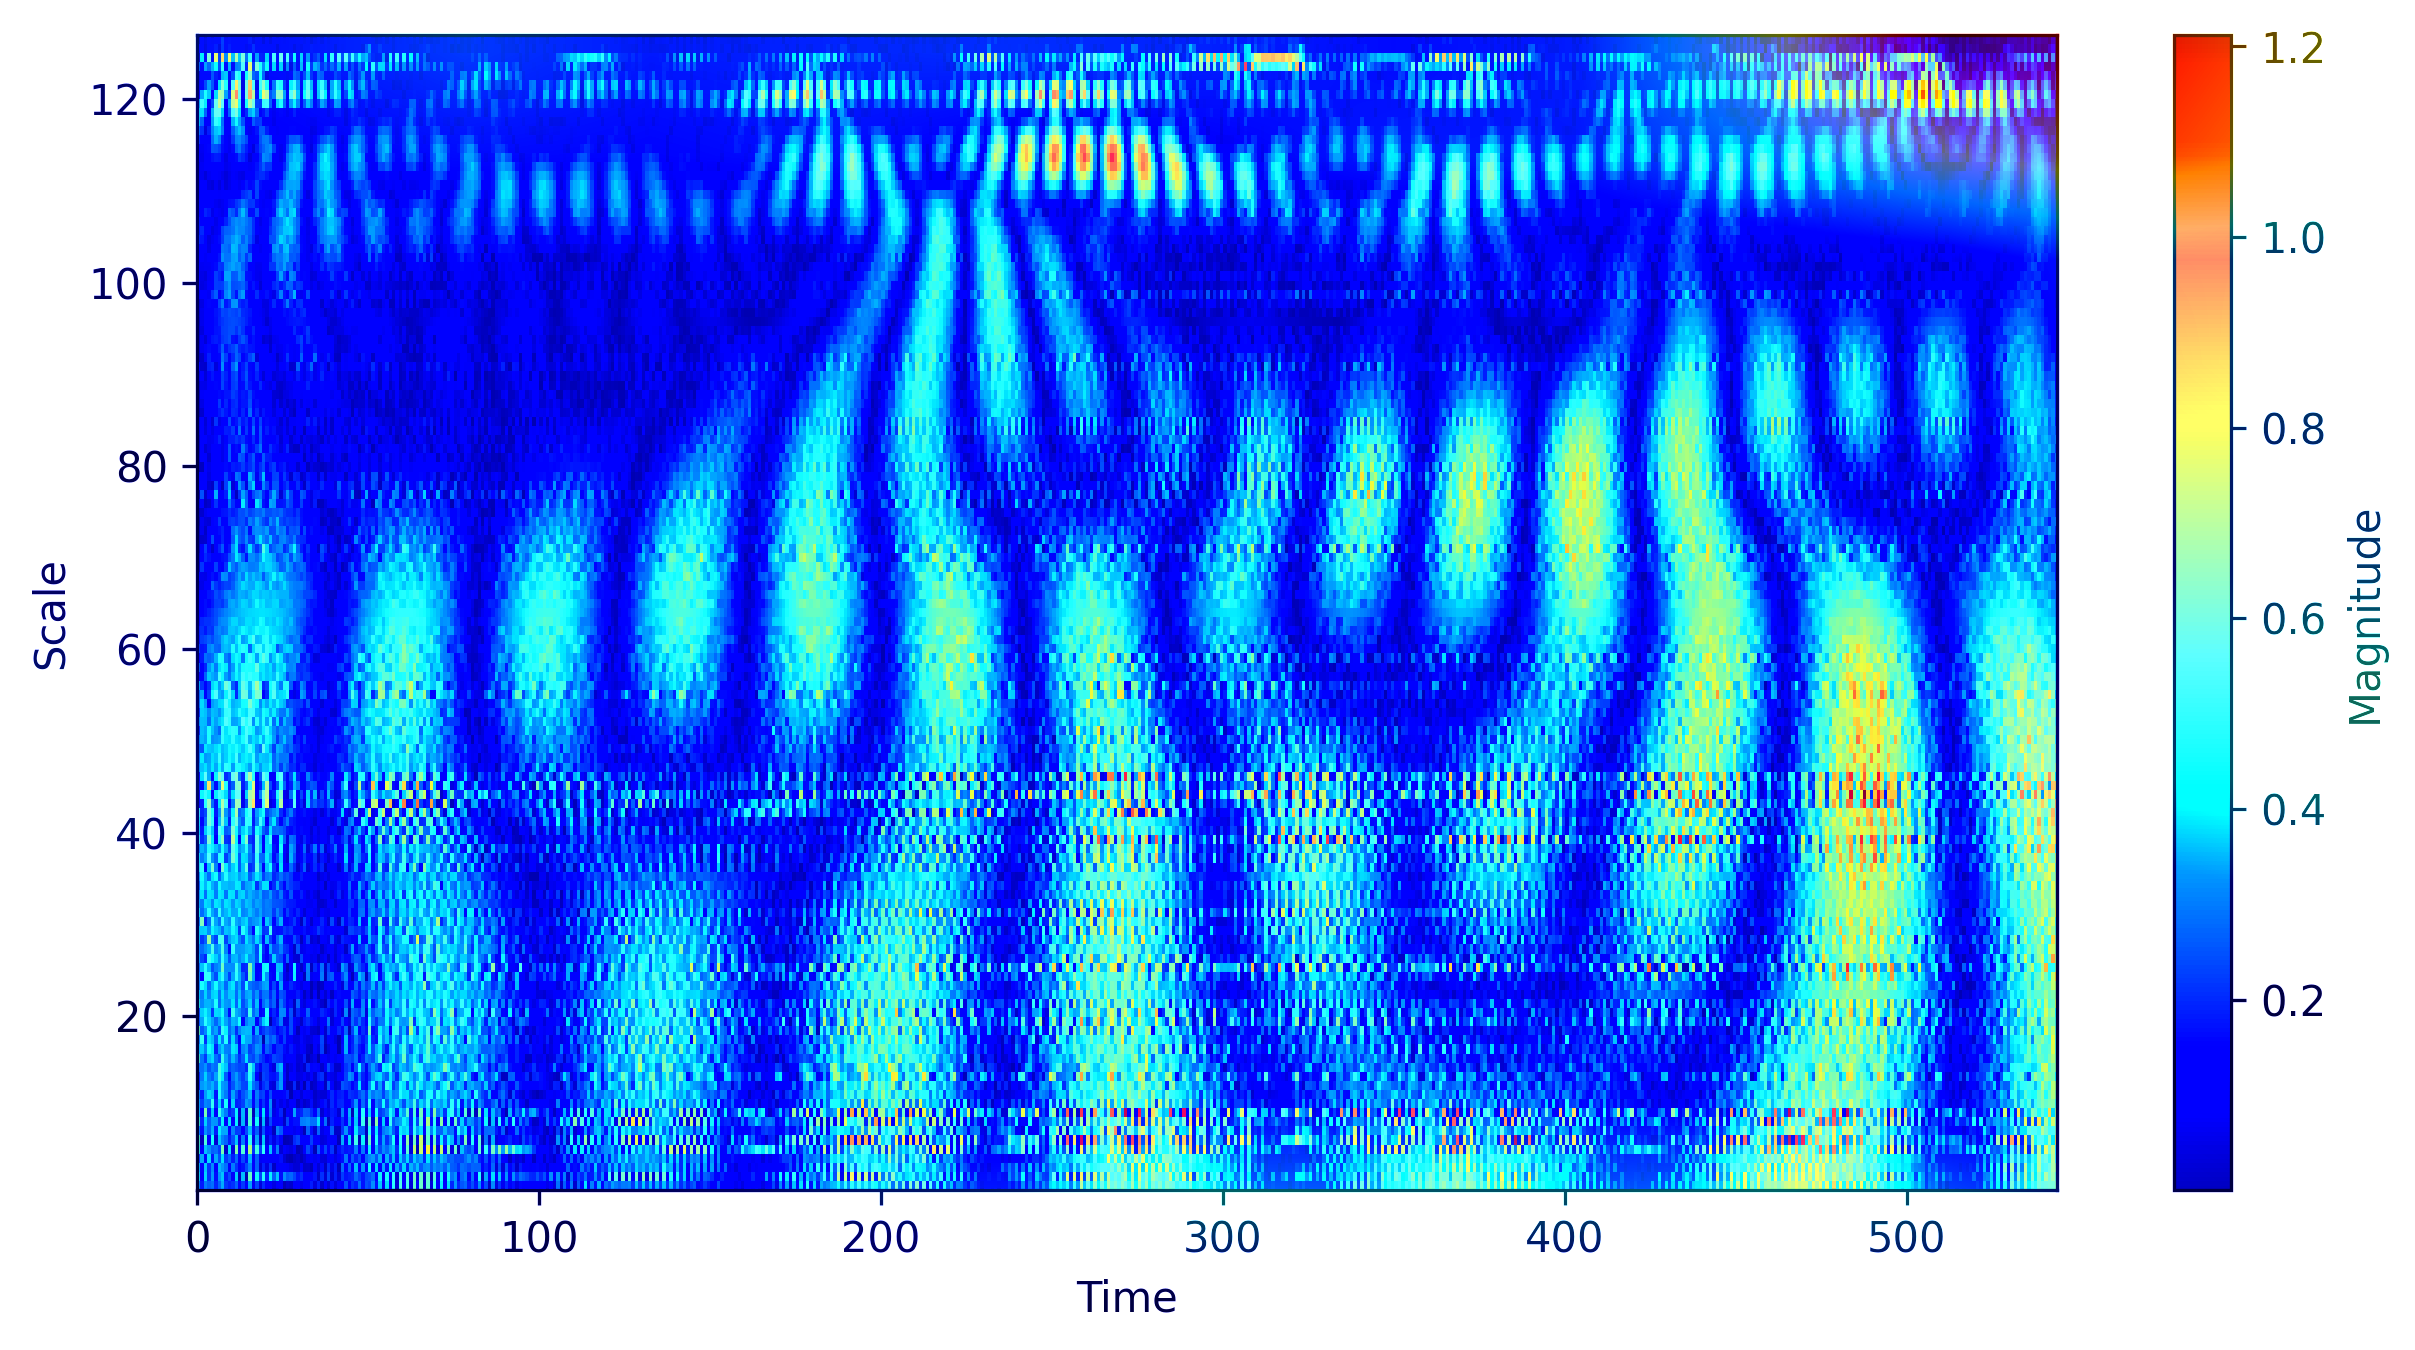

In [32]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)

# **Target**

In [33]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/XAI_p300_target/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)


In [34]:
# set the evaluation mode
alexnet_model.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

In [35]:
img.requires_grad_(True)

tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2

In [36]:
# get the most likely prediction of the model
pred_class = alexnet_model(img).argmax(dim=1).numpy()[0]
pred = alexnet_model(img)


In [37]:
pred[:, pred_class].backward()

In [39]:
# pull the gradients out of the model
gradients = alexnet_model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = alexnet_model.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(256):
    activations[:, i, :, :] *= pooled_gradients[i]

In [40]:
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()


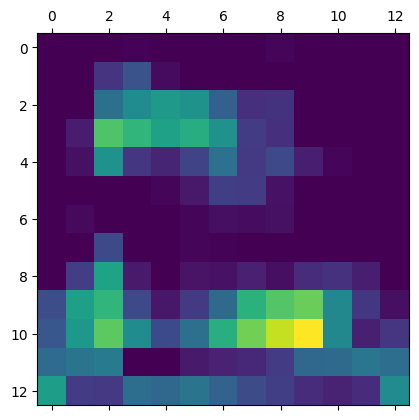

In [41]:
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [42]:
import cv2
img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/xAI/0/03_trial_51__nontarget.png')

heatmap = cv2.resize(np.array(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
# cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/Explainability/Dataset/Elephant/map.jpg', superimposed_img)

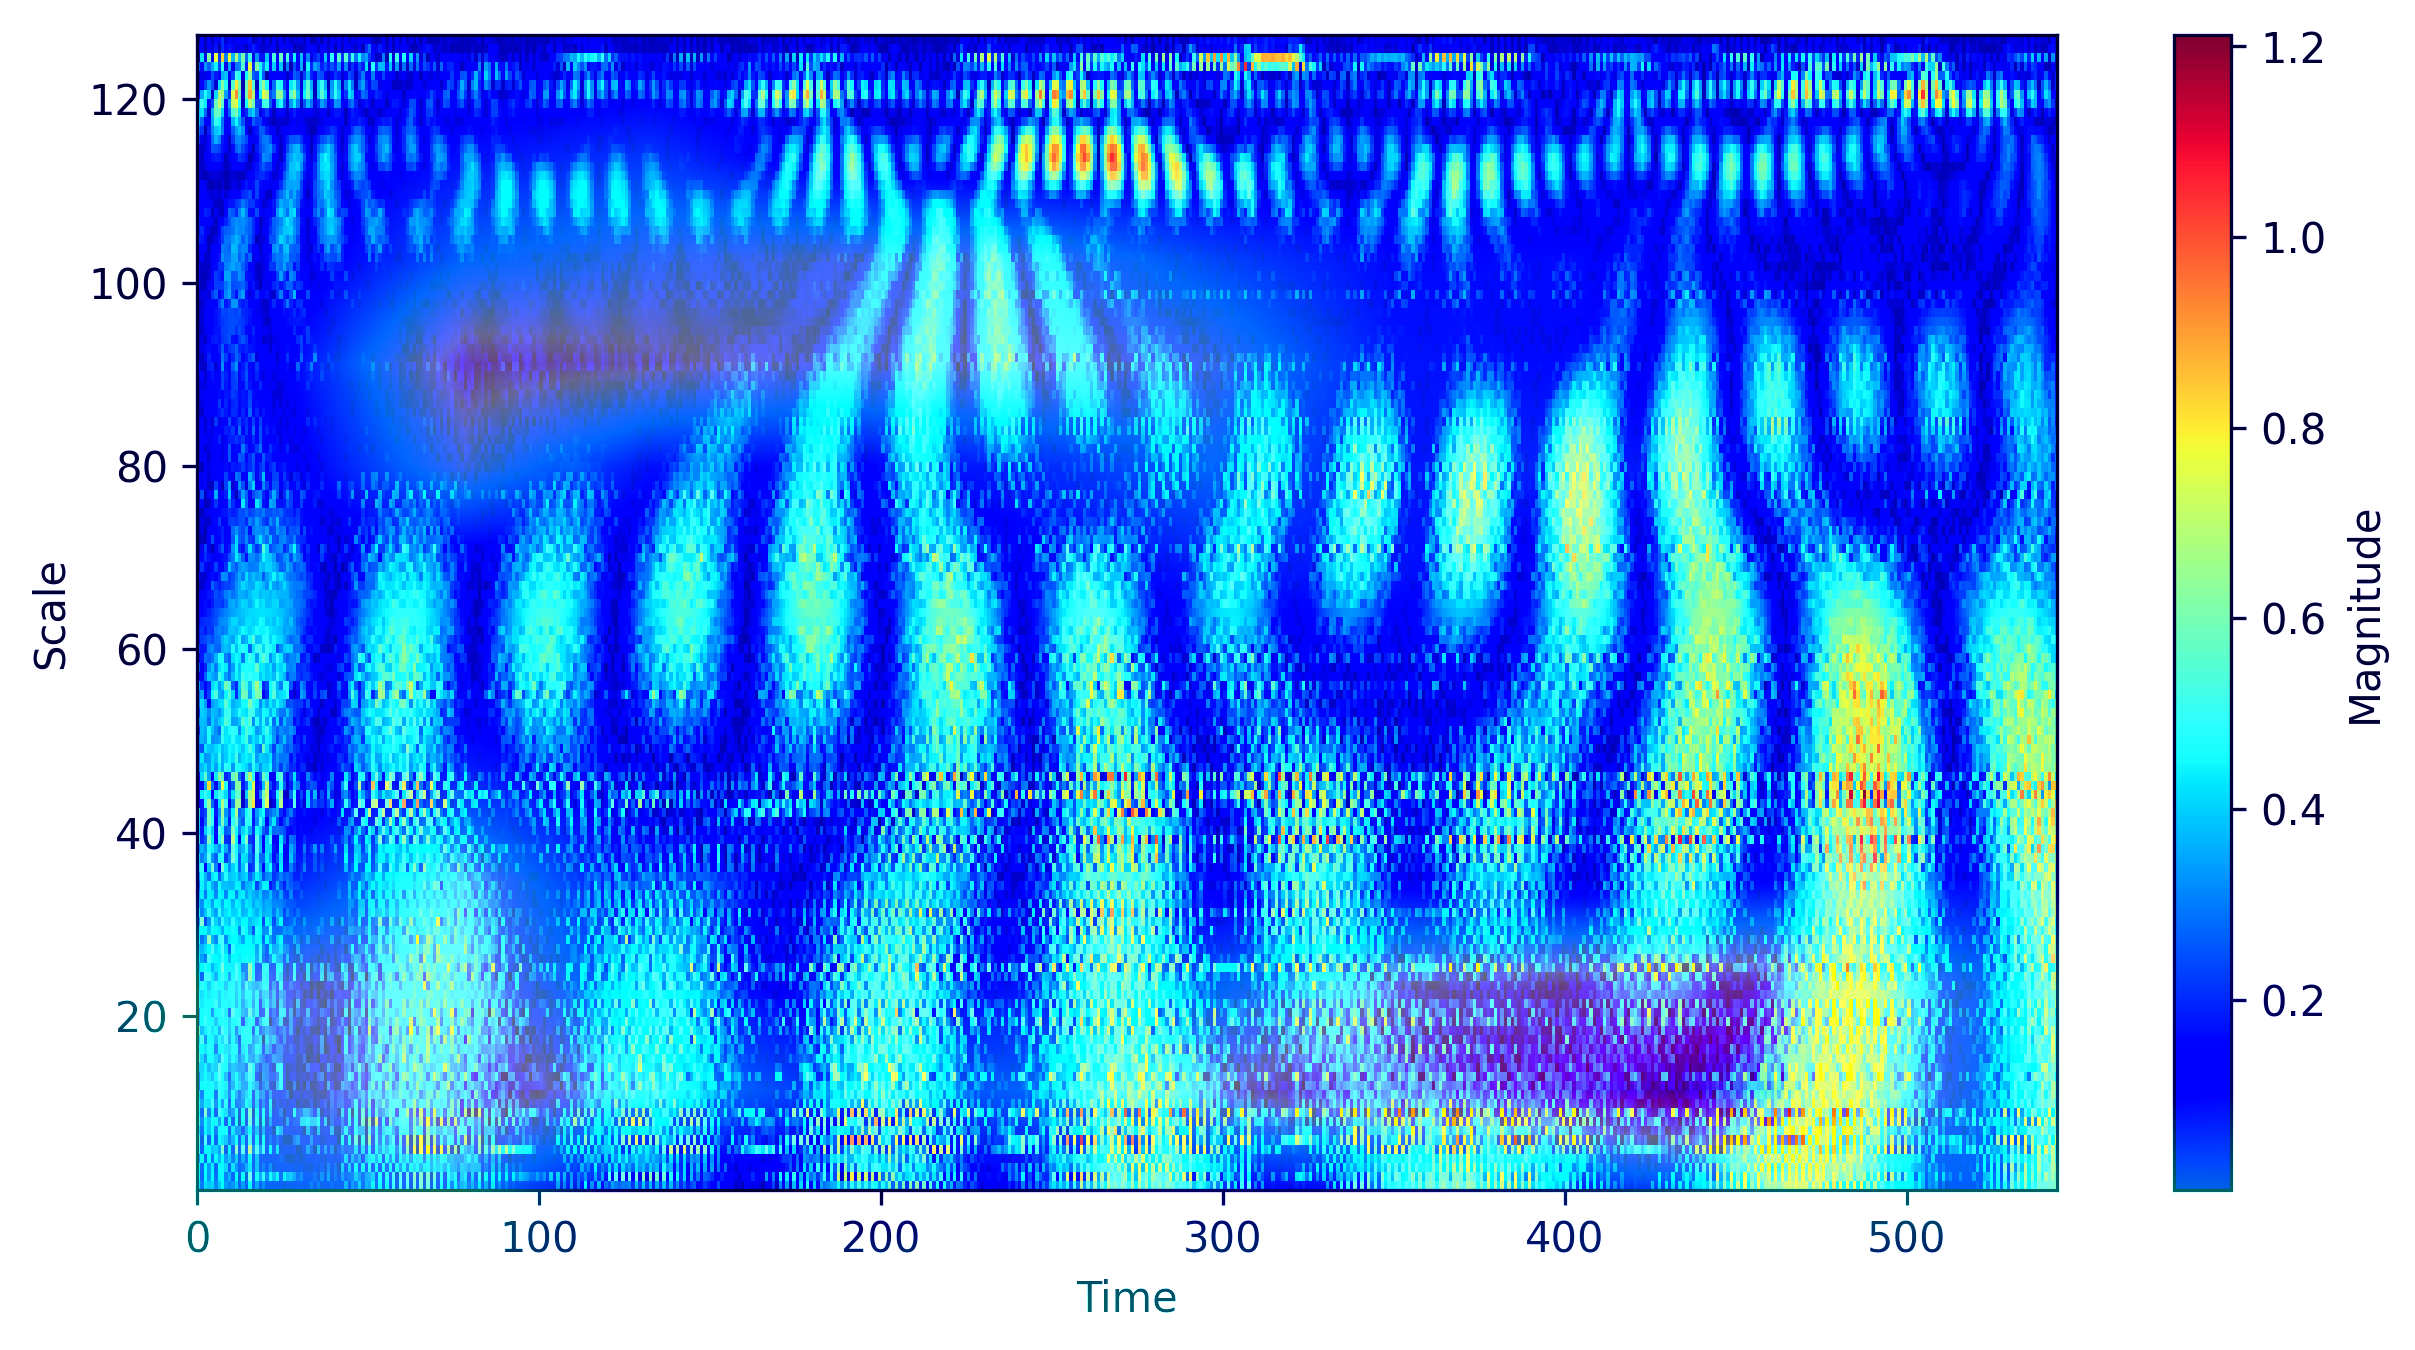

In [43]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)

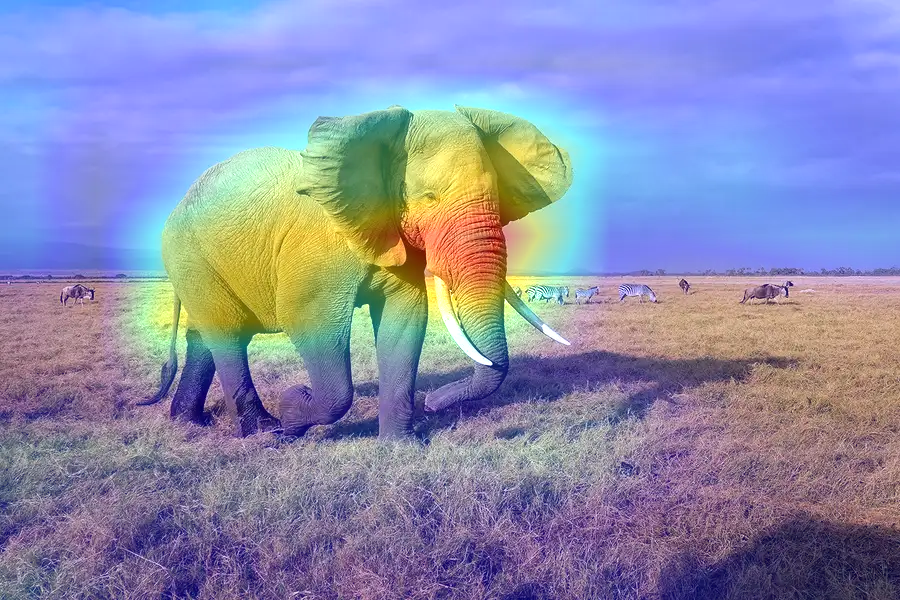

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)